# 必要な計算環境

* Linux OS
* Pascal, Volta, Turing, 或いは NVIDIA Ampere 世代 GPU
* Nvidia Driver
* Docker

# 事前準備

* [NGC](https://catalog.ngc.nvidia.com/?filters=&orderBy=weightPopularDESC&query=&page=&pageSize=)の登録と[APIキー](https://org.ngc.nvidia.com/setup/api-key)の取得は済みましたか？
* [Weights and Biases]((https://docs.wandb.ai/quickstart)) の登録と[APIキー](https://docs.wandb.ai/guides/track/public-api-guide#authentication)の取得は済みましたか？

### NGC のセットアップ
NGCからモデルをダウンロードしたい場合は、APIキーが必要になりますので、取得してください。
### Weights and Biases のセットアップ
モデルのトレーニング進行状況やチャートは、 [Weights and Biases](https://docs.wandb.ai/quickstart) を通じて可視化できます。ログを有効にするために、 [API キー](https://docs.wandb.ai/guides/track/public-api-guide#authentication)を設定してください。

In [1]:
import os
#os.environ["WANDB_ENTITY"]="wandb-healthcare"
os.environ["WANDB_PROJECT"]="BioNeMo_Molecule_LLM"

# GPUの確認

In [2]:
!nvidia-smi

Fri May 31 04:03:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:07:00.0 Off |                    0 |
| N/A   31C    P0              63W / 400W |  24066MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# データの前処理

BioNeMo Frameworkのモデルトレーニング機能を簡単に紹介するために、サンプルデータセットとして提供されている元のZINC15データセットの非常に小さなサブセットを使用します。このサブセットは、下記のコマンドを実行することで、 /workspace/bionemo/examples/molecule/molmim/data に保存します。

このテスト実行のために、フォルダには/train、/val、/testの各フォルダが含まれており、それぞれのフォルダにはCSVファイル形式のSMILESの分子構造式が含まれています。これらのディレクトリ内で、それぞれ何ファイルが作成されたかを確認し、以下の例のコマンドにおける TRAIN_FILE_RANGE、VAL_FILE_RANGE、TEST_FILE_RANGE のパラメータをそれに応じて修正してください。現在のコマンド設定では、train、val および test ディレクトリには 1 ファイルずつが扱われるように設定され、それぞれが299069、2、1486個のサンプルが含まれています。

In [3]:
cd /workspace/bionemo

/workspace/bionemo


In [4]:
!python examples/molecule/molmim/pretrain.py\
 --config-path conf\
 --config-name molmim_70m_24_3\
 ++do_training=False\
 ++trainer.devices=1 \
 ++trainer.num_nodes=1 \
 ++model.data.dataset_path=/workspace/bionemo/examples/molecule/molmim/data \
 ++model.data.links_file=/workspace/bionemo/examples/molecule/megamolbart/dataset/ZINC-downloader-sample.txt \
 ++exp_manager.create_wandb_logger=False

[NeMo I 2024-05-31 04:04:11 megatron_hiddens:110] Registered hidden transform sampled_var_cond_gaussian at bionemo.model.core.hiddens_support.SampledVarGaussianHiddenTransform
[NeMo I 2024-05-31 04:04:11 megatron_hiddens:110] Registered hidden transform interp_var_cond_gaussian at bionemo.model.core.hiddens_support.InterpVarGaussianHiddenTransform
[NeMo W 2024-05-31 04:04:11 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
    See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
      ret = run_job(
    
[NeMo I 2024-05-31 04:04:11 pretrain:25] 
    
    ************** Experiment configuration ***********
[NeMo I 2024-05-31 04:04:11 pretrain:26] 
    model:
      encoder:
        num_layers: 6
        hidden_size: 512
        ffn_hidden_size: ${multiply:${.hidden_size}, 4}
        num_attention_heads:

In [5]:
"""
import wandb
with wandb.init(name="data_upload") as run:
    artifact = wandb.Artifact(
        name="small_ZINC",
        type="dataset",
        description="subset of ZINC",
        metadata={"path":"/workspace/bionemo/examples/molecule/molmim/data"},
    )
    artifact.add_dir("/workspace/bionemo/examples/molecule/molmim/data")
    run.log_artifact(artifact)
"""

'\nimport wandb\nwith wandb.init(name="data_upload") as run:\n    artifact = wandb.Artifact(\n        name="small_ZINC",\n        type="dataset",\n        description="subset of ZINC",\n        metadata={"path":"/workspace/bionemo/examples/molecule/molmim/data"},\n    )\n    artifact.add_dir("/workspace/bionemo/examples/molecule/molmim/data")\n    run.log_artifact(artifact)\n'

# モデルの事前学習

このテスト実行では、/workspace/bionemo/examples/molecule/molmim/conf フォルダにある pretrain_small_canonicalized_logv.yaml 設定ファイルに提供されている事前設定されたパラメータを使用します。これは、MolMIM-70M-24.3 チェックポイントをトレーニングするために使用された設定です。

In [6]:
cd /workspace/bionemo 

/workspace/bionemo


データのサイズによって、TRAIN_FILE_RANGE、TEST_FILE_RANGE、VAL_FILE_RANGEを設定してください。

In [7]:
#TRAIN_FILE_RANGE="x_OP_000..175_CL_"
#TEST_FILE_RANGE="x_OP_000..004_CL_"
#VAL_FILE_RANGE="x_OP_000..175_CL_"

TRAIN_FILE_RANGE="x000"
TEST_FILE_RANGE="x000"
VAL_FILE_RANGE="x000"

In [8]:
import os
os.environ["HYDRA_FULL_ERROR"]="1"

In [9]:
!python examples/molecule/molmim/pretrain.py\
 --config-path conf\
 --config-name molmim_70m_24_3\
 ++trainer.devices=1 \
 ++trainer.num_nodes=1 \
 ++trainer.max_steps=1000 \
 ++trainer.accumulate_grad_batches=1 \
 ++trainer.val_check_interval=5 \
 ++trainer.limit_val_batches=1.0 \
 ++trainer.precision=32 \
 ++model.micro_batch_size=128 \
 ++model.global_batch_size=128 \
 ++model.dwnstr_task_validation.enabled=False \
 ++model.data.dataset_path=examples/molecule/molmim/data \
 ++model.data.dataset.train=$TRAIN_FILE_RANGE \
 ++model.data.dataset.val=$VAL_FILE_RANGE \
 ++model.data.dataset.test=$TEST_FILE_RANGE \
 ++model.data.index_mapping_dir=/results/data_index/ \
 ++model.seq_length=128 \
 ++exp_manager.exp_dir=/results/logs/ \
 ++exp_manager.create_wandb_logger=False

[NeMo I 2024-05-31 04:04:59 megatron_hiddens:110] Registered hidden transform sampled_var_cond_gaussian at bionemo.model.core.hiddens_support.SampledVarGaussianHiddenTransform
[NeMo I 2024-05-31 04:04:59 megatron_hiddens:110] Registered hidden transform interp_var_cond_gaussian at bionemo.model.core.hiddens_support.InterpVarGaussianHiddenTransform
[NeMo W 2024-05-31 04:04:59 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
    See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
      ret = run_job(
    
[NeMo I 2024-05-31 04:04:59 pretrain:25] 
    
    ************** Experiment configuration ***********
[NeMo I 2024-05-31 04:04:59 pretrain:26] 
    model:
      encoder:
        num_layers: 6
        hidden_size: 512
        ffn_hidden_size: ${multiply:${.hidden_size}, 4}
        num_attention_heads:

# CMA-ESを使用したMolMIMによる特性ガイド分子最適化

このセッションは、BioNeMo Framework からMolMIMのチェックポイントをロードし、カスタムのユーザー定義スコアリング機能を使用して興味のあるいくつかの分子を最適化する方法を示します。CMA-ESを使用してMolMIMモデルの潜在空間をトラバースし、スコアリング機能によって測定されたパフォーマンスを向上させると期待される新しい関連分子を選択します。これらの分子をサンプリングするためには、以下のステップを完了する必要があります：

1. 望むMolMIMチェックポイントをロードする。

2. 開始分子をMolMIMの潜在空間にエンコードする。

3. CMA-ESを実行し、以下を繰り返し実行する：

    * 潜在表現をSMILES文字列にデコードする。
    * これらのSMILES文字列にユーザー定義のスコアリング機能を適用し、SMILES/スコアのペアを生成する。
    * 新しい潜在空間表現のセットをCMA-ESアルゴリズムに要求する。

では、事前学習済みモデルをダウンロードします。モデルをダウンロードするため、ngc をインストールして、ngc config を設定する必要があります。

In [10]:
import os
#os.environ["WANDB_ENTITY"]="wandb-healthcare"
os.environ["WANDB_PROJECT"]="BioNeMo_Molecure_optimization"

In [11]:
!pip install optuna statsmodels -qqq

In [12]:
!wget -q -O /tmp/ngccli_linux.zip --content-disposition https://api.ngc.nvidia.com/v2/resources/nvidia/ngc-apps/ngc_cli/versions/3.38.0/files/ngccli_linux.zip && unzip -o /tmp/ngccli_linux.zip -d /tmp && chmod u+x /tmp/ngc-cli/ngc && rm /tmp/ngccli_linux.zip

Archive:  /tmp/ngccli_linux.zip
  inflating: /tmp/ngc-cli/boto3/examples/s3.rst  
  inflating: /tmp/ngc-cli/boto3/examples/cloudfront.rst  
  inflating: /tmp/ngc-cli/boto3/data/dynamodb/2012-08-10/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/sqs/2012-11-05/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/opsworks/2013-02-18/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/iam/2010-05-08/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2014-10-01/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2015-10-01/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2015-03-01/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2016-09-15/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2016-04-01/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2015-04-15/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2016-11-15/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/s3/2006-03-01/resources-1.json  

そして、ターミナルを開いて、下記のコマンドを入力して、 ngc config set をしてください。

/tmp/ngc-cli/ngc config set

<順番にAPI キー、CLI output format, org, team, aceを入力してください。API キーはNGCのAPIキーを入力してください。Org は ’no-org’ 以外のものを選択して、その他は「Enter」でデフォルト値を入力すれば大丈夫です>

最後に、下記のコマンドを入力すれば、モデルをダウンロードできます。

In [13]:
cd /workspace/bionemo 

/workspace/bionemo


In [14]:
!python download_models.py --download_dir /workspace/bionemo/models molmim_70m_24_3

Running command: ngc --version

Installing NGC CLI to /tmp
Running command: wget -q -O /tmp/ngccli_linux.zip --content-disposition https://api.ngc.nvidia.com/v2/resources/nvidia/ngc-apps/ngc_cli/versions/3.38.0/files/ngccli_linux.zip && unzip -o /tmp/ngccli_linux.zip -d /tmp && chmod u+x /tmp/ngc-cli/ngc && rm /tmp/ngccli_linux.zip

Archive:  /tmp/ngccli_linux.zip
  inflating: /tmp/ngc-cli/boto3/examples/s3.rst  
  inflating: /tmp/ngc-cli/boto3/examples/cloudfront.rst  
  inflating: /tmp/ngc-cli/boto3/data/dynamodb/2012-08-10/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/sqs/2012-11-05/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/opsworks/2013-02-18/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/iam/2010-05-08/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2014-10-01/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2015-10-01/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2015-03-01/resources-1.json  
  inflating: /tmp/

## チェックポイントをmolmim推論ラッパーにロード

In [15]:
from bionemo.utils.hydra import load_model_config
import os
from bionemo.model.molecule.molmim.infer import MolMIMInference
bionemo_home=f"/workspace/bionemo"
os.environ['BIONEMO_HOME'] = bionemo_home
checkpoint_path = f"{bionemo_home}/models/molecule/molmim/molmim_70m_24_3.nemo"
cfg = load_model_config(config_name="molmim_infer.yaml", config_path=f"{bionemo_home}/examples/tests/conf/") # reasonable starting config for molmim inference
# This is the field of the config that we need to set to our desired checkpoint path.
cfg.model.downstream_task.restore_from_path = checkpoint_path
model = MolMIMInference(cfg, interactive=True)

[NeMo I 2024-05-31 04:08:35 megatron_hiddens:110] Registered hidden transform sampled_var_cond_gaussian at bionemo.model.core.hiddens_support.SampledVarGaussianHiddenTransform
[NeMo I 2024-05-31 04:08:35 megatron_hiddens:110] Registered hidden transform interp_var_cond_gaussian at bionemo.model.core.hiddens_support.InterpVarGaussianHiddenTransform
[NeMo I 2024-05-31 04:08:35 utils:333] Restoring model from /workspace/bionemo/models/molecule/molmim/molmim_70m_24_3.nemo
[NeMo I 2024-05-31 04:08:35 utils:337] Loading model class: bionemo.model.molecule.molmim.molmim_model.MolMIMModel
Interactive mode selected, using strategy='auto'


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[NeMo I 2024-05-31 04:08:35 exp_manager:394] Experiments will be logged at /workspace/bionemo/test_results/nemo_experiments/molmim_infer/MolMIM_Inference/2024-05-31_04-08-35
[NeMo I 2024-05-31 04:08:35 utils:306] 
    
    ************** Trainer configuration ***********
[NeMo I 2024-05-31 04:08:35 utils:307] 
    name: MolMIM_Inference
    desc: Minimum configuration for initializing a MolMIM model for inference.
    trainer:
      precision: 16-mixed
      devices: 1
      num_nodes: 1
      accelerator: gpu
      logger: false
      accumulate_grad_batches: 1
    exp_manager:
      explicit_log_dir: null
      exp_dir: ${oc.env:BIONEMO_HOME}/test_results/nemo_experiments/molmim_infer
      name: ${name}
      create_checkpoint_callback: false
      create_wandb_logger: false
      create_tensorboard_logger: false
      wandb_logger_kwargs:
        offline: true
    model:
      encoder:
        num_layers: 6
        hidden_size: 512
        ffn_hidden_size: 2048
        num_attentio

[NeMo W 2024-05-31 04:08:36 megatron_base_model:821] The model: MolMIMModel() does not have field.name: context_parallel_size in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-05-31 04:08:36 megatron_base_model:821] The model: MolMIMModel() does not have field.name: virtual_pipeline_model_parallel_size in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-05-31 04:08:36 megatron_base_model:821] The model: MolMIMModel() does not have field.name: sequence_parallel in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-05-31 04:08:36 megatron_base_model:821] The model: MolMIMModel() does not have field.name: expert_model_parallel_size in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-05-31 04:08:36 megatron_base_model:821] The model: MolMIMModel() does not have field.name: use_cpu_initialization in its cfg. Add this 

[NeMo I 2024-05-31 04:08:36 megatron_init:234] Rank 0 has data parallel group: [0]
[NeMo I 2024-05-31 04:08:36 megatron_init:237] All data parallel group ranks: [[0]]
[NeMo I 2024-05-31 04:08:36 megatron_init:238] Ranks 0 has data parallel rank: 0
[NeMo I 2024-05-31 04:08:36 megatron_init:246] Rank 0 has model parallel group: [0]
[NeMo I 2024-05-31 04:08:36 megatron_init:247] All model parallel group ranks: [[0]]
[NeMo I 2024-05-31 04:08:36 megatron_init:257] Rank 0 has tensor model parallel group: [0]
[NeMo I 2024-05-31 04:08:36 megatron_init:261] All tensor model parallel group ranks: [[0]]
[NeMo I 2024-05-31 04:08:36 megatron_init:262] Rank 0 has tensor model parallel rank: 0
[NeMo I 2024-05-31 04:08:36 megatron_init:276] Rank 0 has pipeline model parallel group: [0]
[NeMo I 2024-05-31 04:08:36 megatron_init:288] Rank 0 has embedding group: [0]
[NeMo I 2024-05-31 04:08:36 megatron_init:294] All pipeline model parallel group ranks: [[0]]
[NeMo I 2024-05-31 04:08:36 megatron_init:295]

[NeMo W 2024-05-31 04:08:36 megatron_base_model:821] The model: MolMIMModel() does not have field.name: context_parallel_size in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-05-31 04:08:36 megatron_base_model:821] The model: MolMIMModel() does not have field.name: virtual_pipeline_model_parallel_size in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-05-31 04:08:36 megatron_base_model:821] The model: MolMIMModel() does not have field.name: sequence_parallel in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-05-31 04:08:36 megatron_base_model:821] The model: MolMIMModel() does not have field.name: expert_model_parallel_size in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-05-31 04:08:36 megatron_base_model:821] The model: MolMIMModel() does not have field.name: use_cpu_initialization in its cfg. Add this 

[NeMo I 2024-05-31 04:08:36 tokenizer_utils:199] Using regex tokenization
[NeMo I 2024-05-31 04:08:36 regex_tokenizer:240] Loading vocabulary from file = /tmp/tmpurbg88f2/dd344353154640acbbaea1d4536fa7d0_molmim.vocab
[NeMo I 2024-05-31 04:08:36 regex_tokenizer:254] Loading regex from file = /tmp/tmpurbg88f2/048c1f797f464dd5b6a90f60f9405827_molmim.model
[NeMo I 2024-05-31 04:08:36 megatron_base_model:315] Padded vocab_size: 640, original vocab_size: 523, dummy tokens: 117.
[NeMo I 2024-05-31 04:08:36 megatron_hiddens:121] NOTE: Adding hiddens transforms and losses
[NeMo I 2024-05-31 04:08:36 megatron_hiddens:149] Added transform q_z_given_x with cfg={'cls_name': 'sampled_var_cond_gaussian', 'hidden_size': 512, 'min_logvar': -6.0, 'max_logvar': 0.0, 'map_var_to_hiddens': False}
[NeMo I 2024-05-31 04:08:36 megatron_hiddens:177] Added loss mim with cfg={'cls_name': 'a_mim', 'loss_weight': 1.0}
[NeMo I 2024-05-31 04:08:36 nlp_overrides:752] Model MolMIMModel was successfully restored from /

[NeMo W 2024-05-31 04:08:37 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/nemo/collections/nlp/modules/common/megatron/fused_bias_dropout_add.py:70: UserWarning: nvfuser integration in TorchScript is deprecated. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/jit/codegen/cuda/interface.cpp:235.)
      return bias_dropout_add_fused_inference_(*args)
    


[NeMo I 2024-05-31 04:08:38 megatron_lm_encoder_decoder_model:1195] Decoding using the greedy-search method...


## ユーザー定義の分子スコアリング機能の設定
このセクションでは、最適化したい独自のスコアリング機能をユーザーが取り込むことができます。この例では、入力分子とのタニモト類似度と定量的薬剤性評価（QED）の組み合わせを最適化します。これは、最初の[MolMIMの論文](https://arxiv.org/abs/2208.09016)からの例に従います：
<h3><center>score=min (QED/0.9, 1) + min (Tanimoto/0.4, 1)</center></h3>
この場合、モデルは最大でQED 0.9とタニモト類似度 0.4までを最適化することを許可します。これらの最大値が達成されたら、それ以上の最適化は行いません。

In [16]:
from typing import List, Optional

import numpy as np

from guided_molecule_gen.oracles import qed, tanimoto_similarity

def score_mixing_function(qeds, similarities):
    # We want to maximize QED and tanimoto similarity up to 0.9 and 0.4, respectively.
    return np.clip(qeds / 0.9, a_min=0.0, a_max=1.0) + np.clip(similarities / 0.4, a_min=0.0, a_max=1.0)

def try_canon(smiles:str) -> Optional[str]:
    try:
        return Chem.MolToSmiles(Chem.MolFromSmiles(smiles), canonical=True)
    except:
        return None

def canonicalize(smiles: List[str]) -> List[str]:
    return [try_canon(s) for s in smiles]


def scoring_function(smiles: List[str], reference:str, **kwargs) -> np.ndarray:
    """Takes a list of SMILES strings and returns an array of scores.

    Args:
        smiles (List[str]): Smiles strings to generate a score for (one each)
        reference (str): Reference molecule (SMILES string) is also used for this scoring function.

    Returns:
        np.ndarray: Array of scores, one for each input SMILES string.
    """
    #csmiles = canonicalize(smiles)
    scores: np.ndarray = score_mixing_function(qed(smiles), tanimoto_similarity(smiles, reference))
    return -1 * scores

## 開始分子の定義
このセクションでは、最適化プロセスのための開始分子を定義します。例として、イマチニブ、エルロチニブ、ギフィチニブを使用します。これらの分子を表すSMILES文字列がRDKitを用いて正準化されていることを確認します。MolMIMはRDKitで正準化されたSMILES文字列のコーパス上で訓練されているため、入力および出力もRDKitで正準化されるべきです。これにより最高のパフォーマンスが得られます。

In [17]:
import wandb
from rdkit import Chem
from rdkit.Chem.QED import qed as rdkit_qed

# SMILES strings and compound names
compound_names = ["Imatinib", "Erlotinib", "Gifitinib"]
starting_smiles = [
    "CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC=CC(=N4)C5=CN=CC=C5", # Imatinib
    "COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C)OCCOC", # Erlotinib
    "C1COCCN1CCCOc2c(OC)cc3ncnc(c3c2)Nc4cc(Cl)c(F)cc4", # Gifitinib
]

# Generate RDKit molecules from SMILES
molecules = [Chem.MolFromSmiles(smile) for smile in starting_smiles]

# Calculate QED scores
starting_qed = [rdkit_qed(mol) for mol in molecules]

# Generate canonical SMILES
canonicalized_smiles = [Chem.MolToSmiles(mol, canonical=True) for mol in molecules]

# Initialize a W&B run
with wandb.init(name="simple-EDA") as run:

    # Create a W&B Table
    table = wandb.Table(columns=["Compound Name", "SMILES", "Canonical SMILES", "Structure"])

    # Add data to the table
    for name, smiles, canonical, mol in zip(compound_names, starting_smiles, canonicalized_smiles, molecules):
        wandb_molecule = wandb.Molecule.from_rdkit(mol)
        table.add_data(name, smiles, canonical, wandb_molecule)

    # Log the table to W&B
    run.log({"Chemical Structures": table})

wandb: Currently logged in as: ruan0128. Use `wandb login --relogin` to force relogin


## オプティマイザの設定とCMA-ESのための推論APIのラッピング
CMA-ESライブラリは、推論モデルの入力/出力が特定の形式であることを期待しています。そのため、これをラップするものを提供し、以下に最適化の設定方法を示します。

In [18]:
from bionemo.model.core.controlled_generation import ControlledGenerationPerceiverEncoderInferenceWrapper

controlled_gen_kwargs = {
    "sampling_method": "beam-search",
    "sampling_kwarg_overrides": {"beam_size": 3, "keep_only_best_tokens": True, "return_scores": False},
}

model_wrapped = ControlledGenerationPerceiverEncoderInferenceWrapper(
    model, enforce_perceiver=True, hidden_steps=1, **controlled_gen_kwargs
)  # just flatten the position for this.

## CMA-ESのチューニング
異なるモデルでは、CMA-ESの最適な設定が異なります。ここでは、シグマの可能な値に対してグリッド検索を行い、最も良い設定でさらに最適化ステップを実行します。このシグマのハイパーパラメータに対する最適化を行うために、Optunaライブラリを使用します。このプロセスはハイパーパラメータ最適化（HPO）と呼ばれます。
wandbでOptunaによるHPOのプロセスと見つかったシグマの最適な値をみていきましょう。

In [19]:
import wandb
from guided_molecule_gen.optimizer import MoleculeGenerationOptimizer
import optuna
from datetime import datetime


def objective(trial, n_steps:int=10):
    sigma = trial.suggest_float('sigma', 0, 2)
    optimizer = MoleculeGenerationOptimizer(
        model_wrapped,
        scoring_function,
        canonicalized_smiles,
        popsize=10,  # larger values will be slower but more thorough
        optimizer_args={"sigma": sigma},
    )

    optimizer.optimize(n_steps)
    final_smiles = optimizer.generated_smis
    final_score = np.mean([np.min(scoring_function(smis_population, reference_smis)) for smis_population,reference_smis in zip(final_smiles, canonicalized_smiles)])
    wandb.log({"score": final_score, "sigma": sigma})
    return final_score

with wandb.init(name=f"Basic_Optuna_{datetime.now().strftime('%Y%m%d_%H%M%S')}") as run:
    study = optuna.create_study()
    study.optimize(objective, n_trials=50)
    # After the study, log the best parameters and the DataFrame
    best_params = study.best_params
    wandb.log({"best_params": best_params})

    # Get a DataFrame of all trials and save it as a W&B Table
    df = study.trials_dataframe()
    wandb_table = wandb.Table(dataframe=df)
    wandb.log({"optuna_history_table": wandb_table})

[I 2024-05-31 04:08:51,406] A new study created in memory with name: no-name-2348c0e8-0c94-48c7-abef-5f561f6f9b71


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=175101, Fri May 31 04:08:52 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=222336, Fri May 31 04:08:52 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=256919, Fri May 31 04:08:52 2024)
[NeMo I 2024-05-31 04:08:52 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:08:54 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:08:57 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:08:59 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:09:01 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:09:03 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:09:14,967] Trial 0 finished with value: -1.7406498959358156 and parameters: {'sigma': 0.29757964491307853}. Best is trial 0 with value: -1.7406498959358156.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=200794, Fri May 31 04:09:15 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=141062, Fri May 31 04:09:15 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=151179, Fri May 31 04:09:15 2024)
[NeMo I 2024-05-31 04:09:15 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:09:17 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:09:19 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:09:21 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:09:23 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:09:25 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:09:36,962] Trial 1 finished with value: -1.231801599454505 and parameters: {'sigma': 1.7129188941132143}. Best is trial 0 with value: -1.7406498959358156.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=223659, Fri May 31 04:09:37 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=180313, Fri May 31 04:09:37 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=186067, Fri May 31 04:09:37 2024)
[NeMo I 2024-05-31 04:09:37 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:09:39 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:09:41 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:09:43 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:09:45 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:09:47 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:09:58,908] Trial 2 finished with value: -1.3775619821375056 and parameters: {'sigma': 1.68299700171505}. Best is trial 0 with value: -1.7406498959358156.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=297586, Fri May 31 04:09:58 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=287849, Fri May 31 04:09:58 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=325112, Fri May 31 04:09:58 2024)
[NeMo I 2024-05-31 04:09:58 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:10:01 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:10:03 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:10:05 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:10:07 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:10:09 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:10:20,829] Trial 3 finished with value: -1.9003420683227332 and parameters: {'sigma': 1.4460241659259667}. Best is trial 3 with value: -1.9003420683227332.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=239900, Fri May 31 04:10:20 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=292437, Fri May 31 04:10:20 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=295963, Fri May 31 04:10:20 2024)
[NeMo I 2024-05-31 04:10:20 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:10:23 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:10:25 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:10:27 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:10:29 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:10:31 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:10:42,753] Trial 4 finished with value: -1.652781995532628 and parameters: {'sigma': 1.1111802870752945}. Best is trial 3 with value: -1.9003420683227332.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=245937, Fri May 31 04:10:42 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=251766, Fri May 31 04:10:42 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=307540, Fri May 31 04:10:42 2024)
[NeMo I 2024-05-31 04:10:42 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:10:45 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:10:47 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:10:49 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:10:51 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:10:53 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:11:04,663] Trial 5 finished with value: -1.9009649836178797 and parameters: {'sigma': 0.8914586939895062}. Best is trial 5 with value: -1.9009649836178797.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=205677, Fri May 31 04:11:04 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=258683, Fri May 31 04:11:04 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=237287, Fri May 31 04:11:04 2024)
[NeMo I 2024-05-31 04:11:04 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:11:06 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:11:09 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:11:11 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:11:13 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:11:15 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:11:26,427] Trial 6 finished with value: -1.373291962345076 and parameters: {'sigma': 1.873116265412382}. Best is trial 5 with value: -1.9009649836178797.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=258288, Fri May 31 04:11:26 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=233344, Fri May 31 04:11:26 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=223459, Fri May 31 04:11:26 2024)
[NeMo I 2024-05-31 04:11:26 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:11:28 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:11:30 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:11:33 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:11:35 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:11:37 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:11:48,423] Trial 7 finished with value: -1.9281005001949547 and parameters: {'sigma': 0.6599078013206365}. Best is trial 7 with value: -1.9281005001949547.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=210851, Fri May 31 04:11:48 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=261753, Fri May 31 04:11:48 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=275624, Fri May 31 04:11:48 2024)
[NeMo I 2024-05-31 04:11:48 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:11:50 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:11:52 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:11:55 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:11:57 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:11:59 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:12:10,376] Trial 8 finished with value: -1.9006839189800668 and parameters: {'sigma': 0.8743699400186791}. Best is trial 7 with value: -1.9281005001949547.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=210513, Fri May 31 04:12:10 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=190272, Fri May 31 04:12:10 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=244454, Fri May 31 04:12:10 2024)
[NeMo I 2024-05-31 04:12:10 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:12:12 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:12:14 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:12:17 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:12:19 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:12:21 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:12:32,366] Trial 9 finished with value: -1.8967342353738292 and parameters: {'sigma': 0.9174035604825816}. Best is trial 7 with value: -1.9281005001949547.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=232394, Fri May 31 04:12:32 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=199635, Fri May 31 04:12:32 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=226011, Fri May 31 04:12:32 2024)
[NeMo I 2024-05-31 04:12:32 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:12:34 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:12:36 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:12:39 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:12:41 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:12:43 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:12:54,427] Trial 10 finished with value: -1.61569207444316 and parameters: {'sigma': 0.05434390029577618}. Best is trial 7 with value: -1.9281005001949547.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=234550, Fri May 31 04:12:54 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=275503, Fri May 31 04:12:54 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=238407, Fri May 31 04:12:54 2024)
[NeMo I 2024-05-31 04:12:54 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:12:56 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:12:58 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:13:01 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:13:03 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:13:05 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:13:16,364] Trial 11 finished with value: -1.9089921034427313 and parameters: {'sigma': 0.5417421022786477}. Best is trial 7 with value: -1.9281005001949547.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=253855, Fri May 31 04:13:16 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=194665, Fri May 31 04:13:16 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=232782, Fri May 31 04:13:16 2024)
[NeMo I 2024-05-31 04:13:16 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:13:18 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:13:20 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:13:23 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:13:25 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:13:27 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:13:38,312] Trial 12 finished with value: -1.9407338108359953 and parameters: {'sigma': 0.4880464164972316}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=220987, Fri May 31 04:13:38 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=213922, Fri May 31 04:13:38 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=246547, Fri May 31 04:13:38 2024)
[NeMo I 2024-05-31 04:13:38 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:13:40 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:13:42 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:13:44 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:13:47 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:13:49 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:14:00,182] Trial 13 finished with value: -1.8797776929778653 and parameters: {'sigma': 0.5321614529094405}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=197270, Fri May 31 04:14:00 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=239106, Fri May 31 04:14:00 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=231298, Fri May 31 04:14:00 2024)
[NeMo I 2024-05-31 04:14:00 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:14:02 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:14:04 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:14:06 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:14:08 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:14:11 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:14:21,944] Trial 14 finished with value: -1.896457481899299 and parameters: {'sigma': 0.5547750529586706}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=258915, Fri May 31 04:14:21 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=264648, Fri May 31 04:14:21 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=249088, Fri May 31 04:14:22 2024)
[NeMo I 2024-05-31 04:14:22 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:14:24 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:14:26 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:14:28 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:14:30 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:14:32 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:14:43,882] Trial 15 finished with value: -1.5085159203262488 and parameters: {'sigma': 0.0043384308727869025}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=292328, Fri May 31 04:14:43 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=302303, Fri May 31 04:14:43 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=300022, Fri May 31 04:14:43 2024)
[NeMo I 2024-05-31 04:14:43 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:14:46 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:14:48 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:14:50 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:14:52 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:14:54 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:15:05,535] Trial 16 finished with value: -1.7554798981611845 and parameters: {'sigma': 1.2729616536328905}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=221315, Fri May 31 04:15:05 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=213892, Fri May 31 04:15:05 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=194772, Fri May 31 04:15:05 2024)
[NeMo I 2024-05-31 04:15:05 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:15:07 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:15:09 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:15:12 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:15:14 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:15:16 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:15:27,385] Trial 17 finished with value: -1.7089565614277813 and parameters: {'sigma': 0.3040672199630277}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=192509, Fri May 31 04:15:27 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=202828, Fri May 31 04:15:27 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=199320, Fri May 31 04:15:27 2024)
[NeMo I 2024-05-31 04:15:27 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:15:29 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:15:31 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:15:33 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:15:36 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:15:38 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:15:49,048] Trial 18 finished with value: -1.9277469457913565 and parameters: {'sigma': 0.7141876852614132}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=234256, Fri May 31 04:15:49 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=171678, Fri May 31 04:15:49 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=235904, Fri May 31 04:15:49 2024)
[NeMo I 2024-05-31 04:15:49 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:15:51 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:15:53 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:15:55 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:15:57 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:15:59 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:16:10,823] Trial 19 finished with value: -1.6708456377350098 and parameters: {'sigma': 0.29357534569941585}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=231493, Fri May 31 04:16:10 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=238478, Fri May 31 04:16:10 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=244980, Fri May 31 04:16:10 2024)
[NeMo I 2024-05-31 04:16:10 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:16:13 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:16:15 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:16:17 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:16:19 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:16:21 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:16:32,496] Trial 20 finished with value: -1.8968442084693473 and parameters: {'sigma': 1.116095777495255}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=215042, Fri May 31 04:16:32 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=198267, Fri May 31 04:16:32 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=211294, Fri May 31 04:16:32 2024)
[NeMo I 2024-05-31 04:16:32 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:16:34 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:16:36 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:16:39 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:16:41 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:16:43 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:16:54,086] Trial 21 finished with value: -1.927272435444367 and parameters: {'sigma': 0.6954051063762603}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=200117, Fri May 31 04:16:54 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=229312, Fri May 31 04:16:54 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=147901, Fri May 31 04:16:54 2024)
[NeMo I 2024-05-31 04:16:54 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:16:56 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:16:58 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:17:00 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:17:02 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:17:04 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:17:15,762] Trial 22 finished with value: -1.8737712480954383 and parameters: {'sigma': 0.7072126625560878}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=233725, Fri May 31 04:17:15 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=240112, Fri May 31 04:17:15 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=290344, Fri May 31 04:17:15 2024)
[NeMo I 2024-05-31 04:17:15 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:17:17 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:17:20 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:17:22 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:17:24 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:17:26 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:17:37,418] Trial 23 finished with value: -1.8966799718701004 and parameters: {'sigma': 0.6937045319677854}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=231109, Fri May 31 04:17:37 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=261908, Fri May 31 04:17:37 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=265031, Fri May 31 04:17:37 2024)
[NeMo I 2024-05-31 04:17:37 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:17:39 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:17:41 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:17:43 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:17:46 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:17:48 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:17:59,166] Trial 24 finished with value: -1.8393565820960713 and parameters: {'sigma': 0.4125369560460429}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=218990, Fri May 31 04:17:59 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=233889, Fri May 31 04:17:59 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=193519, Fri May 31 04:17:59 2024)
[NeMo I 2024-05-31 04:17:59 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:18:01 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:18:03 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:18:05 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:18:07 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:18:09 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:18:20,772] Trial 25 finished with value: -1.931787243913597 and parameters: {'sigma': 0.7713681246807782}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=277878, Fri May 31 04:18:20 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=261578, Fri May 31 04:18:20 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=213832, Fri May 31 04:18:20 2024)
[NeMo I 2024-05-31 04:18:20 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:18:22 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:18:25 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:18:27 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:18:29 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:18:31 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:18:42,463] Trial 26 finished with value: -1.664628955791767 and parameters: {'sigma': 0.20995123469405363}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=215617, Fri May 31 04:18:42 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=201379, Fri May 31 04:18:42 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=237205, Fri May 31 04:18:42 2024)
[NeMo I 2024-05-31 04:18:42 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:18:44 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:18:46 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:18:49 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:18:51 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:18:53 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:19:04,111] Trial 27 finished with value: -1.8742448797182962 and parameters: {'sigma': 1.0919751434589557}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=178575, Fri May 31 04:19:04 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=238132, Fri May 31 04:19:04 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=164406, Fri May 31 04:19:04 2024)
[NeMo I 2024-05-31 04:19:04 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:19:06 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:19:08 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:19:10 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:19:12 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:19:14 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:19:25,697] Trial 28 finished with value: -1.8795102727263056 and parameters: {'sigma': 0.43617122825103527}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=291158, Fri May 31 04:19:25 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=302250, Fri May 31 04:19:25 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=215225, Fri May 31 04:19:25 2024)
[NeMo I 2024-05-31 04:19:25 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:19:27 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:19:30 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:19:32 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:19:34 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:19:36 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:19:47,346] Trial 29 finished with value: -1.6708456377350098 and parameters: {'sigma': 0.16320692276687399}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=253395, Fri May 31 04:19:47 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=243401, Fri May 31 04:19:47 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=231968, Fri May 31 04:19:47 2024)
[NeMo I 2024-05-31 04:19:47 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:19:49 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:19:51 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:19:53 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:19:55 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:19:58 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:20:08,828] Trial 30 finished with value: -1.578858545868427 and parameters: {'sigma': 1.3321265144792618}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=247512, Fri May 31 04:20:08 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=253056, Fri May 31 04:20:08 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=267383, Fri May 31 04:20:08 2024)
[NeMo I 2024-05-31 04:20:08 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:20:11 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:20:13 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:20:15 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:20:17 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:20:19 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:20:30,360] Trial 31 finished with value: -1.9153486677653255 and parameters: {'sigma': 0.7731690572475372}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=183507, Fri May 31 04:20:30 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=180835, Fri May 31 04:20:30 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=210561, Fri May 31 04:20:30 2024)
[NeMo I 2024-05-31 04:20:30 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:20:32 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:20:34 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:20:36 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:20:38 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:20:41 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:20:51,891] Trial 32 finished with value: -1.8855561215433436 and parameters: {'sigma': 0.6053961466818607}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=263284, Fri May 31 04:20:51 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=307523, Fri May 31 04:20:51 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=230609, Fri May 31 04:20:51 2024)
[NeMo I 2024-05-31 04:20:51 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:20:54 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:20:56 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:20:58 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:21:00 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:21:02 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:21:13,389] Trial 33 finished with value: -1.873906007473926 and parameters: {'sigma': 0.8146045434609034}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=211455, Fri May 31 04:21:13 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=175531, Fri May 31 04:21:13 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=215968, Fri May 31 04:21:13 2024)
[NeMo I 2024-05-31 04:21:13 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:21:15 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:21:17 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:21:19 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:21:22 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:21:24 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:21:34,949] Trial 34 finished with value: -1.8736095254749159 and parameters: {'sigma': 0.38359054034455675}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=279885, Fri May 31 04:21:34 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=254921, Fri May 31 04:21:34 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=177079, Fri May 31 04:21:35 2024)
[NeMo I 2024-05-31 04:21:35 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:21:37 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:21:39 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:21:41 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:21:43 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:21:45 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:21:56,478] Trial 35 finished with value: -1.8972312026715683 and parameters: {'sigma': 0.9861756525824316}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=207464, Fri May 31 04:21:56 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=248944, Fri May 31 04:21:56 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=229082, Fri May 31 04:21:56 2024)
[NeMo I 2024-05-31 04:21:56 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:21:58 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:22:00 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:22:02 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:22:05 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:22:07 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:22:17,994] Trial 36 finished with value: -1.9100330997886221 and parameters: {'sigma': 0.6485979538209626}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=198613, Fri May 31 04:22:18 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=227939, Fri May 31 04:22:18 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=168181, Fri May 31 04:22:18 2024)
[NeMo I 2024-05-31 04:22:18 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:22:20 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:22:22 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:22:24 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:22:26 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:22:28 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:22:39,573] Trial 37 finished with value: -1.9156796701809824 and parameters: {'sigma': 0.4591979914031139}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=253676, Fri May 31 04:22:39 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=215963, Fri May 31 04:22:39 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=246242, Fri May 31 04:22:39 2024)
[NeMo I 2024-05-31 04:22:39 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:22:41 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:22:43 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:22:46 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:22:48 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:22:50 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:23:01,117] Trial 38 finished with value: -1.8678215838613397 and parameters: {'sigma': 0.8059544966663268}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=230102, Fri May 31 04:23:01 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=189363, Fri May 31 04:23:01 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=150642, Fri May 31 04:23:01 2024)
[NeMo I 2024-05-31 04:23:01 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:23:03 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:23:05 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:23:07 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:23:09 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:23:11 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:23:22,602] Trial 39 finished with value: -1.3686581513552365 and parameters: {'sigma': 1.5655443666142146}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=226974, Fri May 31 04:23:22 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=271361, Fri May 31 04:23:22 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=218044, Fri May 31 04:23:22 2024)
[NeMo I 2024-05-31 04:23:22 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:23:24 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:23:26 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:23:29 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:23:31 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:23:33 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:23:44,169] Trial 40 finished with value: -1.90142800110259 and parameters: {'sigma': 1.0097538783025217}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=176221, Fri May 31 04:23:44 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=181297, Fri May 31 04:23:44 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=205699, Fri May 31 04:23:44 2024)
[NeMo I 2024-05-31 04:23:44 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:23:46 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:23:48 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:23:50 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:23:52 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:23:54 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:24:05,756] Trial 41 finished with value: -1.8963760110895127 and parameters: {'sigma': 0.7196676371993134}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=307238, Fri May 31 04:24:05 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=210923, Fri May 31 04:24:05 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=219231, Fri May 31 04:24:05 2024)
[NeMo I 2024-05-31 04:24:05 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:24:07 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:24:10 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:24:12 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:24:14 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:24:16 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:24:27,372] Trial 42 finished with value: -1.830243350841924 and parameters: {'sigma': 0.8954575041437005}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=206836, Fri May 31 04:24:27 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=238675, Fri May 31 04:24:27 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=210361, Fri May 31 04:24:27 2024)
[NeMo I 2024-05-31 04:24:27 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:24:29 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:24:31 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:24:33 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:24:36 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:24:38 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:24:48,952] Trial 43 finished with value: -1.9299064581342147 and parameters: {'sigma': 0.5855256515233407}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=243662, Fri May 31 04:24:48 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=325039, Fri May 31 04:24:48 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=132980, Fri May 31 04:24:49 2024)
[NeMo I 2024-05-31 04:24:49 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:24:51 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:24:53 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:24:55 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:24:57 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:24:59 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:25:10,546] Trial 44 finished with value: -1.8890392235332254 and parameters: {'sigma': 0.5885032573384495}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=222669, Fri May 31 04:25:10 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=239515, Fri May 31 04:25:10 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=199784, Fri May 31 04:25:10 2024)
[NeMo I 2024-05-31 04:25:10 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:25:12 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:25:14 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:25:17 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:25:19 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:25:21 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:25:31,986] Trial 45 finished with value: -0.9381162982551272 and parameters: {'sigma': 1.930174271899449}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=165276, Fri May 31 04:25:32 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=180615, Fri May 31 04:25:32 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=148948, Fri May 31 04:25:32 2024)
[NeMo I 2024-05-31 04:25:32 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:25:34 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:25:36 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:25:38 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:25:40 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:25:42 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:25:53,597] Trial 46 finished with value: -1.889017549033797 and parameters: {'sigma': 0.47402840025945503}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=284177, Fri May 31 04:25:53 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=268036, Fri May 31 04:25:53 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=199969, Fri May 31 04:25:53 2024)
[NeMo I 2024-05-31 04:25:53 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:25:55 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:25:57 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:26:00 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:26:02 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:26:04 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:26:15,230] Trial 47 finished with value: -1.8494510871246064 and parameters: {'sigma': 0.3379524409444945}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=201460, Fri May 31 04:26:15 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=187213, Fri May 31 04:26:15 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=179661, Fri May 31 04:26:15 2024)
[NeMo I 2024-05-31 04:26:15 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:26:17 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:26:19 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:26:21 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:26:23 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:26:26 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:26:36,866] Trial 48 finished with value: -1.884223863827513 and parameters: {'sigma': 0.4944364899675311}. Best is trial 12 with value: -1.9407338108359953.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=233984, Fri May 31 04:26:36 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=234056, Fri May 31 04:26:36 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=316299, Fri May 31 04:26:36 2024)
[NeMo I 2024-05-31 04:26:36 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:26:39 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:26:41 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:26:43 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:26:45 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-31 04:26:47 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-05-31 04:26:58,503] Trial 49 finished with value: -1.6666490543092618 and parameters: {'sigma': 0.19409490775863425}. Best is trial 12 with value: -1.9407338108359953.


score,▂▆▅▁▁▅▁▁▃▁▁▁▄▂▃▁▁▁▁▁▁▃▁▁▄▁▁▁▁▁▁▂▁▁▂▁█▁▂▃
sigma,▂▇▇▆▄█▃▄▁▃▃▃▁▆▂▄▅▄▄▄▄▂▅▃▆▄▃▄▅▃▃▄▅▄▄▃█▃▂▂
score,-1.66665
sigma,0.19409


上記の値はHPOプロセスで得られた最適値ですが、有効な値の範囲を考慮し、よりロバストであろう最小値を選択します。HPOプロセスは確率的なため、高性能な値と低性能な値が近接して存在することがあります。オプティマイザが一般的に良好に機能するシグマ値の適切な範囲を特定したいと考えています。滑らかにした最適な選択と、最も良い名目上の選択をwandb上で比較しましょう

smooth_best: {'sigma': 0.6834170854271356} simple_best_param: {'sigma': 0.4880464164972316}


smoothed_best_sigma,▁
smoothed_best_sigma,0.68342


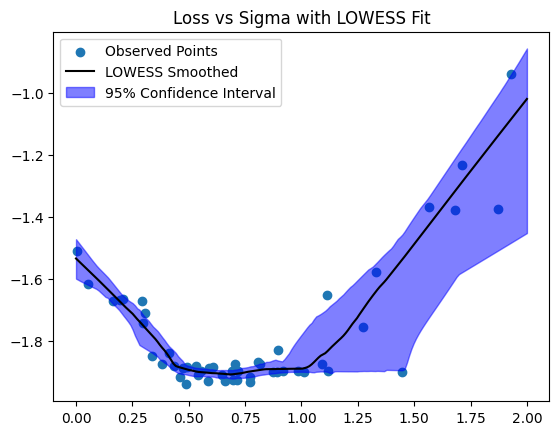

In [20]:
import wandb
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from guided_molecule_gen.optimizer import MoleculeGenerationOptimizer
from datetime import datetime


def lowess_with_confidence_bounds(x, y, eval_x, N=200, conf_interval=0.95, lowess_kw=None):
    """
    Perform Lowess regression and determine a confidence interval by bootstrap resampling.
    """
    # Lowess smoothing
    smoothed = sm.nonparametric.lowess(exog=x, endog=y, xvals=eval_x, **lowess_kw)

    # Bootstrap resampling for confidence intervals
    smoothed_values = np.empty((N, len(eval_x)))
    for i in range(N):
        sample = np.random.choice(len(x), len(x), replace=True)
        sampled_x = x[sample]
        sampled_y = y[sample]
        smoothed_values[i, :] = sm.nonparametric.lowess(exog=sampled_x, endog=sampled_y, xvals=eval_x, **lowess_kw)
        

    # Confidence intervals
    sorted_values = np.sort(smoothed_values, axis=0)
    bound = int(N * (1 - conf_interval) / 2)
    bottom = sorted_values[bound - 1]
    top = sorted_values[-bound]

    return smoothed, bottom, top


# Initialize a W&B run
with wandb.init(name=f"HPO_visualization_{datetime.now().strftime('%Y%m%d_%H%M%S')}") as run:
    # Generate data, fit and plot
    completed_trials = [trial for trial in study.trials if trial.state == optuna.trial.TrialState.COMPLETE]
    trials_data = [{"sigma": trial.params["sigma"], "loss": trial.value, "trial_id": tid} for tid,trial in enumerate(completed_trials)]
    data = pd.DataFrame(trials_data)
    data = pd.DataFrame(trials_data)
    eval_x = np.linspace(0, 2, 200)
    smoothed, bottom, top = lowess_with_confidence_bounds(data.sigma, data.loss, eval_x, lowess_kw={"frac": 0.33})

    # Create plot

    fig, ax = plt.subplots()
    ax.scatter(data["sigma"], data["loss"], label="Observed Points")
    ax.plot(eval_x, smoothed, 'k', label="LOWESS Smoothed")
    ax.fill_between(eval_x, bottom, top, color='blue', alpha=0.5, label="95% Confidence Interval")
    ax.legend()
    ax.set_title("Loss vs Sigma with LOWESS Fit")
    
    # Log the plot to W&B
    run.log({"LOWESS Plot": wandb.Image(fig)})

    # Additional data to log
    smoothed_best_sigma = eval_x[np.argmin(smoothed)]  # Use the smoothed minimum
    run.log({"best_params": study.best_params, "smoothed_best_sigma": smoothed_best_sigma})
    smooth_best = {"sigma": smoothed_best_sigma}
    print("smooth_best:", smooth_best, "simple_best_param:",study.best_params)

## CMA-ES最適化
### 発見されたパラメータを用いて、より大規模なCMA-ES最適化を実行する
HPOで見つかったシグマの値が効果的であることが確認できたため、分子集団のサイズとステップ数を増やし、最後により大規模な最適化を実行します。

### 結果の探索
最適化のパフォーマンスを評価するために、生成された無効なサンプルの数を定量化することができます。「無効」とは、化学的に有効な分子を表さないSMILES文字列を指します。
実行後、ターゲット（QEDおよびタニモト類似度）の成分が各イテレーションでどのように変化したかを示すグラフを作成します。ターゲットの定義により、タニモト類似度が0.4以上の値が最適とされるため、その値の周囲にノイズが発生することが予想されます。同様に、QEDにおいても0.9以上の値が最適とされるため、その閾値を超える分子がある場合にはその値の周囲にノイズが発生することが予想されます。
WandBで結果を確認しましょう。

### 最適化のパフォーマンスはどれほど良かったのか？
最適化のパフォーマンスを評価するために、生成された無効なサンプルの数を定量化することができます。「無効」とは、化学的に有効な分子を表さないSMILES文字列を指します。

-> wandb内の`num_of_bad_samples`を確認しましょう

最終的に、ベースライン値に対するQEDの改善度と、望ましいタニモト類似度の閾値0.4以上を維持した最適化された分子の割合を定量化することができます。

-> wandb内の`mean_qed_improvement`、`tanimoto_above_04`を確認しましょう。

(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 512 (seed=197800, Fri May 31 04:27:17 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 512 (seed=207910, Fri May 31 04:27:17 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 512 (seed=224550, Fri May 31 04:27:17 2024)


  0%|                                                    | 0/30 [00:00<?, ?it/s]

[NeMo I 2024-05-31 04:27:17 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


  3%|█▍                                          | 1/30 [00:04<02:11,  4.52s/it]

[NeMo I 2024-05-31 04:27:21 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


  7%|██▉                                         | 2/30 [00:08<02:02,  4.38s/it]

[NeMo I 2024-05-31 04:27:26 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 10%|████▍                                       | 3/30 [00:13<01:59,  4.43s/it]

[NeMo I 2024-05-31 04:27:30 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 13%|█████▊                                      | 4/30 [00:17<01:53,  4.36s/it]

[NeMo I 2024-05-31 04:27:34 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 17%|███████▎                                    | 5/30 [00:22<01:50,  4.43s/it]

[NeMo I 2024-05-31 04:27:39 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 20%|████████▊                                   | 6/30 [00:26<01:45,  4.38s/it]

[NeMo I 2024-05-31 04:27:43 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 23%|██████████▎                                 | 7/30 [00:30<01:41,  4.41s/it]

[NeMo I 2024-05-31 04:27:47 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 27%|███████████▋                                | 8/30 [00:35<01:35,  4.36s/it]

[NeMo I 2024-05-31 04:27:52 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 30%|█████████████▏                              | 9/30 [00:39<01:32,  4.39s/it]

[NeMo I 2024-05-31 04:27:56 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 33%|██████████████▎                            | 10/30 [00:43<01:27,  4.36s/it]

[NeMo I 2024-05-31 04:28:01 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 37%|███████████████▊                           | 11/30 [00:48<01:23,  4.39s/it]

[NeMo I 2024-05-31 04:28:05 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 40%|█████████████████▏                         | 12/30 [00:52<01:18,  4.34s/it]

[NeMo I 2024-05-31 04:28:09 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 43%|██████████████████▋                        | 13/30 [00:57<01:14,  4.38s/it]

[NeMo I 2024-05-31 04:28:14 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 47%|████████████████████                       | 14/30 [01:01<01:09,  4.34s/it]

[NeMo I 2024-05-31 04:28:18 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 50%|█████████████████████▌                     | 15/30 [01:05<01:05,  4.39s/it]

[NeMo I 2024-05-31 04:28:22 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 53%|██████████████████████▉                    | 16/30 [01:09<01:00,  4.34s/it]

[NeMo I 2024-05-31 04:28:27 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 57%|████████████████████████▎                  | 17/30 [01:14<00:56,  4.37s/it]

[NeMo I 2024-05-31 04:28:31 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 60%|█████████████████████████▊                 | 18/30 [01:18<00:52,  4.34s/it]

[NeMo I 2024-05-31 04:28:35 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 63%|███████████████████████████▏               | 19/30 [01:23<00:48,  4.36s/it]

[NeMo I 2024-05-31 04:28:40 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 67%|████████████████████████████▋              | 20/30 [01:27<00:43,  4.32s/it]

[NeMo I 2024-05-31 04:28:44 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 70%|██████████████████████████████             | 21/30 [01:31<00:39,  4.36s/it]

[NeMo I 2024-05-31 04:28:48 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 73%|███████████████████████████████▌           | 22/30 [01:35<00:34,  4.32s/it]

[NeMo I 2024-05-31 04:28:53 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 77%|████████████████████████████████▉          | 23/30 [01:40<00:30,  4.36s/it]

[NeMo I 2024-05-31 04:28:57 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 80%|██████████████████████████████████▍        | 24/30 [01:44<00:25,  4.32s/it]

[NeMo I 2024-05-31 04:29:01 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 83%|███████████████████████████████████▊       | 25/30 [01:49<00:21,  4.36s/it]

[NeMo I 2024-05-31 04:29:06 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 87%|█████████████████████████████████████▎     | 26/30 [01:53<00:17,  4.32s/it]

[NeMo I 2024-05-31 04:29:10 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 90%|██████████████████████████████████████▋    | 27/30 [01:57<00:13,  4.37s/it]

[NeMo I 2024-05-31 04:29:14 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 93%|████████████████████████████████████████▏  | 28/30 [02:02<00:08,  4.34s/it]

[NeMo I 2024-05-31 04:29:19 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 97%|█████████████████████████████████████████▌ | 29/30 [02:06<00:04,  4.38s/it]

[NeMo I 2024-05-31 04:29:23 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


100%|███████████████████████████████████████████| 30/30 [02:10<00:00,  4.36s/it]


num_of_bad_samples: 0.0036559139784946232 mean_qed_improvement: 0.46211030214165705 tanimoto_above_04: 0.6666666666666666


mean_qed_improvement,▁
num_of_bad_samples,▁
tanimoto_above_04,▁
mean_qed_improvement,0.46211
num_of_bad_samples,0.00366
tanimoto_above_04,0.66667


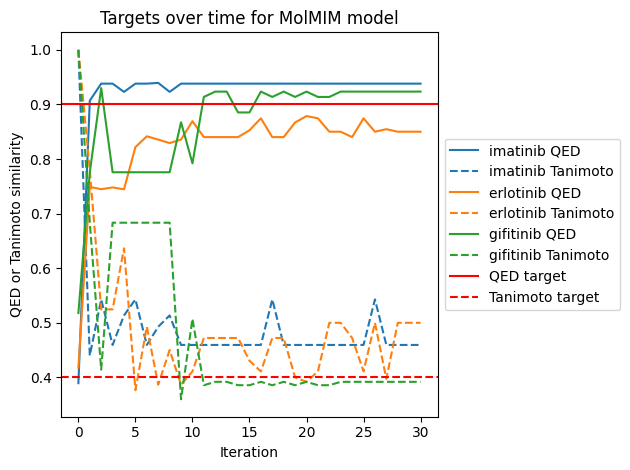

In [21]:
import wandb
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from guided_molecule_gen.optimizer import MoleculeGenerationOptimizer
from tqdm import trange
from datetime import datetime

# Initialize a W&B run
with wandb.init(name=f"CMS_EA_Optimization_{datetime.now().strftime('%Y%m%d_%H%M%S')}") as run:
    # Assuming model_wrapped and scoring_function are defined elsewhere
    optimizer = MoleculeGenerationOptimizer(
        model_wrapped,
        scoring_function,
        canonicalized_smiles,
        popsize=50,  # larger values will be slower but more thorough
        optimizer_args=smooth_best,  # Vals from HPO
    )
    
    columns = ["iteration", "idx","molecure", "smiles", "structure", "qud_score", "tanimoto_score"]
    optimization_results = wandb.Table(columns=columns)

    # Starting state for idx 0
    qed_scores = [qed(canonicalized_smiles)]
    tanimoto_scores = [[tanimoto_similarity([canonicalized_smiles[idx]], canonicalized_smiles[idx])[0] for idx in range(len(canonicalized_smiles))]]
    best_molecules = [canonicalized_smiles]
    fraction_bad_samples = [[0] * len(canonicalized_smiles)]

    for i in trange(30):
        optimizer.step()
        final_smiles = optimizer.generated_smis
        # Population of molecules is returned, but we only want the best one.
        _qed_scores = []
        _tanimoto_scores = []
        _best_molecules = []
        _fraction_bad = []
        ca_id = 0
        for smis_population, reference_smis in zip(final_smiles, canonicalized_smiles):
            idx = np.argmin(scoring_function(smis_population, reference_smis))
            _fraction_bad.append(np.mean(qed(smis_population) == 0))
            _best_molecules.append(smis_population[idx])
            _qed_scores.append(qed([smis_population[idx]])[0])
            _tanimoto_scores.append(tanimoto_similarity([smis_population[idx]], reference_smis)[0])
            
            
            mol = Chem.MolFromSmiles(smis_population[idx])
            wandb_molecule = wandb.Molecule.from_rdkit(mol)
            
            optimization_results.add_data(i, idx,["imatinib", "erlotinib", "gifitinib"][ca_id], smis_population[idx], wandb_molecule, qed([smis_population[idx]])[0], tanimoto_similarity([smis_population[idx]], reference_smis)[0])
            ca_id=+1

        qed_scores.append(_qed_scores)
        tanimoto_scores.append(_tanimoto_scores)
        best_molecules.append(_best_molecules)
        fraction_bad_samples.append(_fraction_bad)

    run.log({"optimization_results":optimization_results})

    # Plotting results
    fig, ax = plt.subplots()
    for i, molecule in enumerate(["imatinib", "erlotinib", "gifitinib"]):
        line, = plt.plot(np.arange(len(qed_scores)), [q[i] for q in qed_scores], label=f"{molecule} QED")
        color = line.get_color()
        plt.plot(np.arange(len(tanimoto_scores)), [t[i] for t in tanimoto_scores], label=f"{molecule} Tanimoto", linestyle="--", color=color)
    plt.axhline(y=0.9, color='r', linestyle='-', label="QED target")
    plt.axhline(y=0.4, color='r', linestyle='--', label="Tanimoto target")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Iteration")
    plt.ylabel("QED or Tanimoto similarity")
    plt.title("Targets over time for MolMIM model")
    plt.tight_layout()

    # Log the plot to W&B
    run.log({"LOWESS Plot": wandb.Image(fig)})

    # Additional calculations and logs
    qed_improvements = []
    tanimoto_above_04 = []
    for i in range(len(starting_qed)):
        tanimoto_above_04.append(tanimoto_scores[-1][i] >= 0.4)
        qed_improvements.append(qed_scores[-1][i] - starting_qed[i])
    
    metrics = {
        "num_of_bad_samples": np.mean(fraction_bad_samples),
        "mean_qed_improvement": np.mean(qed_improvements),
        "tanimoto_above_04": np.mean(tanimoto_above_04),
    }
    
    run.log(metrics)
    
    # Print metrics
    print("num_of_bad_samples:", np.mean(fraction_bad_samples),"mean_qed_improvement:", metrics["mean_qed_improvement"], "tanimoto_above_04:", metrics["tanimoto_above_04"])
